[View in Colaboratory](https://colab.research.google.com/github/iamrajee/Data-Analysis/blob/master/article_senti3.ipynb)

In [1]:
!ls

datalab


In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}





# !mkdir -p drive
# !google-drive-ocamlfuse drive


# !ls

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

import keras

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
keras.__version__

Using TensorFlow backend.


'2.1.6'

In [0]:
# !pip install xlrd

In [0]:
# import xlrd
# xlsx_file = "drive/ML/mancy/labelled training set.xlsx"
# dfs = pd.read_excel(xlsx_file)#, sheetname="sheet1")
# dfs

In [0]:
# filenamelistold = dfs['filename']
# neglist = dfs['negative']
# neulist = dfs['neutral']
# poslist = dfs['positive']

# sentimentlist = []
# filenamelist = []

# for i in range(0,len(filenamelistold)):
#   neg = neglist[i]
#   neu = neulist[i]
#   pos = poslist[i]
#   sent = filenamelistold[i]
#   if neg == 1:
#     sentimentlist.append(0)
#     filenamelist.append(sent)
#   elif neu == 1:
#     sentimentlist.append(1)
#     filenamelist.append(sent)
#   elif pos == 1:
#     sentimentlist.append(2)
#     filenamelist.append(sent)
    
# print(len(filenamelistold), len(filenamelist))

In [30]:
# text = "At present that is not treated as shorting because stock is delivered to cover the transaction. In reality, it's shorting by another name because the seller doesn't own the stock it delivers to cover its selling."
# text.find("short")

34

In [0]:
# path1 = 'drive/ML/mancy/training_set_articles/'

# x_refined_data = []
# y_refined_data = []

# for i in range(0, len(filenamelist)):
#   path2 = path1 + filenamelist[i]
#   with open(path2, 'r', encoding="ISO-8859-1") as f:
#     for line in f:
#       if "short" in line:
#         if "selling" in line or "sale" in line or "sell" in line or "positions" in line or "sold" in line:
#           for subline in line.split(". "):
#             if ("hort s" in subline or "hort-s" in subline or "hort (s" in subline or "hort p" in subline or "hort- s" in subline or "sold short" in subline or "selling short" in subline or "sell short" in subline or "hort S" in subline or "hort-S" in subline or "sell short" in subline or "hort - s" in subline or "hort - S" in subline or "hortsell" in subline or "hort, s" in subline or "hort' (s" in subline or '""short""' in subline or "position short" in subline or "shares short" in subline or "stocks short" in subline or "funds falling short" in subline or "short fund sales" in subline or "sales shortfall" in subline) == 1:
#                 x_refined_data.append(subline)
#                 y_refined_data.append(sentimentlist[i])

# print(len(x_refined_data), len(y_refined_data))

In [0]:
# # !pip install tables
# # !pip install openpyxl
# import openpyxl
# import tables
# x_refined_datadf = pd.DataFrame({'sentence':x_refined_data})
# y_refined_datadf = pd.DataFrame({'sentiment':y_refined_data})

# finaldf = pd.concat([x_refined_datadf, y_refined_datadf], axis=1)
# filename = 'drive/ML/mancy/' + "labelleddata.hdf" 
# finaldf.to_hdf('./labelleddata.h5','data')

# !ls

# from google.colab import files
# downloaded = files.download("labelleddata.h5")

In [0]:
# !pip install tables
# !pip install openpyxl
import openpyxl
import tables
finaldf = pd.read_hdf('./drive/ML/mancy/labelleddata.h5','data')
x_refined_data = finaldf['sentence']
y_refined_data = finaldf['sentiment']

In [0]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [51]:
%%time
tokenizer.fit_on_texts(x_refined_data)

CPU times: user 90.5 ms, sys: 830 µs, total: 91.4 ms
Wall time: 93.6 ms


In [0]:
if num_words is None:
    num_words = len(tokenizer.word_index)

In [53]:
print(num_words)
# tokenizer.word_index

10000


In [0]:
from sklearn.model_selection import train_test_split
x_refined_data_train, x_refined_data_test, y_train, y_test = train_test_split(x_refined_data, y_refined_data, test_size=0.2, random_state=2)

x_train_tokens = tokenizer.texts_to_sequences(x_refined_data_train)
x_test_tokens = tokenizer.texts_to_sequences(x_refined_data_test)

In [55]:
print(len(x_train_tokens), len(x_test_tokens))

1930 483


In [56]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)
print(np.min(num_tokens),np.mean(num_tokens),np.max(num_tokens))
max_tokens = np.max(num_tokens)

2 26.610443431413177 95


In [0]:
pad = 'pre'

x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [58]:
print(x_train_pad.shape ,x_test_pad.shape)

(1930, 95) (483, 95)


In [0]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [0]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    
    # Concatenate all words.   
    text = " ".join(words)

    return text

In [0]:
# x_refined_data[1]

In [62]:
tokens_to_string(x_train_tokens[1])

"the sfc investigation claimed that tiger asia had sold short 93 million shares in china construction bank after having been approached to take part in a placement of the bank's shares in january 2009"

In [0]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train2 = encoder.fit_transform(y_train)

In [0]:
model = Sequential()

In [0]:
embedding_size = 32

In [66]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))
model.add(LSTM(units=16, return_sequences=True))
model.add(LSTM(units=8, return_sequences=True))
model.add(LSTM(units=4))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=3.5e-6),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 95, 32)            320000    
_________________________________________________________________
lstm_13 (LSTM)               (None, 95, 16)            3136      
_________________________________________________________________
lstm_14 (LSTM)               (None, 95, 8)             800       
_________________________________________________________________
lstm_15 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 15        
Total params: 324,159
Trainable params: 324,159
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%time
n_epochs = 100
hist = model.fit(x_train_pad, y_train2,
          validation_split=0.05, epochs=n_epochs, batch_size=64)

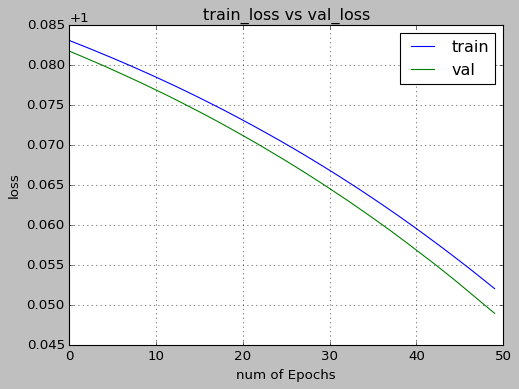

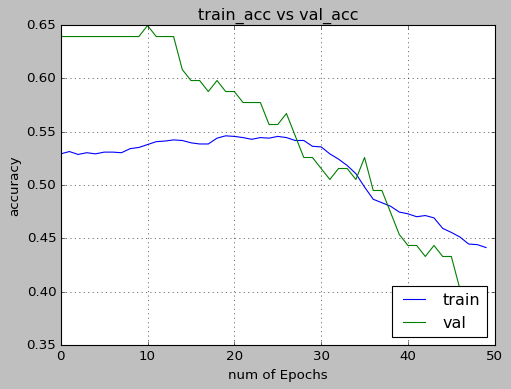

In [36]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(n_epochs)



plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])





plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])